##    第1章　データアップ、APIまわり
---


**1-1. データは事前にdriveにzipのままアップロードしているので、マウントするだけでokです(して下さい)**

はじめに[Kaggle](https://www.kaggle.com/)のアカウントからAPIを使うためにjson持ってきて入れましょう

In [0]:
from google.colab import files
files.upload()

jsonを入れれたらcolab上で使えるように権限を変えましょう

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -l /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

**1-2. データセットについてです**

今回はデータが多いのでdrive側にzipで保存しています。なので解凍しましょう

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!ls /content/gdrive/'My Drive'/ML/kaggle_dataset/NYC_TaxiFare/

In [0]:
%%time
!unzip /content/gdrive/'My Drive'/ML/kaggle_dataset/NYC_TaxiFare/train.csv.zip

Archive:  /content/gdrive/My Drive/ML/kaggle_dataset/NYC_TaxiFare/train.csv.zip
  inflating: train.csv               train.csv


ok
CPU times: user 381 ms, sys: 59.2 ms, total: 440 ms
Wall time: 1min 7s


## 第2章　ライブラリの追加

---



今回はNNの定義にkerasを使うのでKerasを入れます。

(サンプルデータの際にはデータ数をを100倍に増やしたいのでimbalanced-learnで増やします)

In [0]:
!pip install kaggle
!pip install keras
!pip install lightgbm
!pip install xgboost
# !pip install imbalanced-learn -U

## 第3章　実際にやってみる
---

**最初にライブラリをインポートしましょう。**

In [3]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split


import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,Activation,Dropout
from keras.utils import np_utils
from keras.optimizers import SGD

Using TensorFlow backend.


**サンプルデータ読み取り**

次元は比較的少ないですが、147500640件ってデータ量がすごくすごいですね

datetimeに関しては年月日で別の変数で作成した方が良さそうです

In [4]:
# あまりにも重い場合は読み込み制限をかける
df_train= pd.read_csv("/content/train.csv")# , nrows=10000000) 
df_test  = pd.read_csv("gdrive/My Drive/ML/kaggle_dataset/NYC_TaxiFare/test.csv")

print('train size: %d\n'%df_train.size)
print(df_train.dtypes)
df_train.head(5)

train size: 147500640

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


続いて testの中身も見てみましょう。

基本的にfare以外は変わらないので安心ですが、testでも60000越えはやっかいですね。

In [5]:
print('test size: %d\n'%df_test.size)
print(df_test.dtypes)
df_test.head(5)

test size: 69398

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [0]:
# df_sample = df_origin.sample(n=1000000)
# df_train= df_origin[df_origin["flg"]==0]
# df_test= df_origin[df_origin["flg"]==1]

# # trainの2割をvalidationに使用
# df_train, df_valid =  train_test_split(df_train, test_size=0.5)

# df_origin = df_origin.iloc[0:0]
# del df_origin

とりあえず、全体の雰囲気を確かめましょう。

* すると、fare(運賃)のminにマイナスの値が入っていることを確認。バグかな？
* あとは、count(乗客)のmaxに208人と大所帯が入っていることも確認。トロイの木馬いる
* って、latitude(緯度), lognitude(経度)も -3000 ってどこの世界ですか..?

(ちなみに50%は中央値、ほかのn%も同じ感じ)

In [6]:
pd.options.display.float_format = '{:.2f}'.format
df_train.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,18437580,18437579.00,18437579,18437579.00,18437579.00,18437456.00,18437456.00,18437579.00
unique,18437580,nan,10629525,nan,nan,nan,nan,nan
top,2010-08-26 21:13:01.0000002,nan,2011-11-06 01:14:00 UTC,nan,nan,nan,nan,nan
freq,1,nan,29,nan,nan,nan,nan,nan
mean,NaN,11.34,NaN,-72.51,39.92,-72.51,39.92,1.69
std,NaN,9.80,NaN,12.98,9.40,12.91,9.46,1.32
min,NaN,-107.75,NaN,-3439.25,-3492.26,-3442.02,-3493.65,0.00
25%,NaN,6.00,NaN,-73.99,40.73,-73.99,40.73,1.00
50%,NaN,8.50,NaN,-73.98,40.75,-73.98,40.75,1.00
75%,NaN,12.50,NaN,-73.97,40.77,-73.96,40.77,2.00


とりあえず 運賃0未満の強盗未遂とトロイのタクシーとどこかの世界の経度緯度は削除します。

(本来は緯度-90~90, 経度-180~180ですが、北半球のUSなので-の緯度と+の経度は省略しました)


約10万/1.4億件だけみたいだったので安心です。平均の値等にあまり変更はなさそうです。

In [7]:
print("before : %d"%df_train.size)
df_train = df_train[(df_train["fare_amount"] >= 0) & (df_train["passenger_count"]  <=  6)]

df_train = df_train[(df_train["pickup_longitude"] <=  0) & (df_train["pickup_longitude"] >= -180)]
df_train = df_train[(df_train["dropoff_longitude"] <=  0) & (df_train["dropoff_longitude"] >= -180)]

df_train = df_train[(df_train["pickup_latitude"]  <= 90) & (df_train["pickup_latitude"]  >= 0)]
df_train = df_train[(df_train["dropoff_latitude"]  <= 90) & (df_train["dropoff_latitude"]  >= 0)]
print("after  : %d"%df_train.size)

df_train.describe(include='all')

before : 147500640
after  : 147404304


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,18425538,18425538.00,18425538,18425538.00,18425538.00,18425538.00,18425538.00,18425538.00
unique,18425538,nan,10628507,nan,nan,nan,nan,nan
top,2010-08-26 21:13:01.0000002,nan,2011-11-06 01:14:00 UTC,nan,nan,nan,nan,nan
freq,1,nan,29,nan,nan,nan,nan,nan
mean,NaN,11.34,NaN,-72.56,39.98,-72.56,39.98,1.68
std,NaN,9.80,NaN,10.13,5.57,10.12,5.56,1.31
min,NaN,0.00,NaN,-168.60,0.00,-173.96,0.00,0.00
25%,NaN,6.00,NaN,-73.99,40.73,-73.99,40.73,1.00
50%,NaN,8.50,NaN,-73.98,40.75,-73.98,40.75,1.00
75%,NaN,12.50,NaN,-73.97,40.77,-73.96,40.77,2.00


testデータも同じ雰囲気か見てみましょう

In [8]:
df_test.describe(include='all')

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914,9914,9914.00,9914.00,9914.00,9914.00,9914.00
unique,9914,1753,nan,nan,nan,nan,nan
top,2011-12-13 22:00:00.000000109,2011-12-13 22:00:00 UTC,nan,nan,nan,nan,nan
freq,1,270,nan,nan,nan,nan,nan
mean,NaN,NaN,-73.97,40.75,-73.97,40.75,1.67
std,NaN,NaN,0.04,0.03,0.04,0.04,1.28
min,NaN,NaN,-74.25,40.57,-74.26,40.57,1.00
25%,NaN,NaN,-73.99,40.74,-73.99,40.74,1.00
50%,NaN,NaN,-73.98,40.75,-73.98,40.75,1.00
75%,NaN,NaN,-73.97,40.77,-73.96,40.77,2.00


testデータでの緯度経度の分散の小ささから、もう少し絞っても良さそうです。

In [9]:
print("before : %d"%df_train.size)
df_train = df_train[(df_train["pickup_longitude"]  <=  df_test['pickup_longitude'].max()) & (df_train["pickup_longitude"]  >= df_test['pickup_longitude'].min())]
df_train = df_train[(df_train["dropoff_longitude"] <=  df_test['pickup_longitude'].max()) & (df_train["dropoff_longitude"] >= df_test['pickup_longitude'].min())]

df_train = df_train[(df_train["pickup_latitude"]   <= df_test['pickup_latitude'].max()) & (df_train["pickup_latitude"]   >= df_test['pickup_latitude'].min())]
df_train = df_train[(df_train["dropoff_latitude"]  <= df_test['pickup_latitude'].max()) & (df_train["dropoff_latitude"]  >= df_test['pickup_latitude'].min())]

print("after  : %d"%df_train.size)

df_train.describe(include='all')

before : 147404304
after  : 144333480


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,18041685,18041685.00,18041685,18041685.00,18041685.00,18041685.00,18041685.00,18041685.00
unique,18041685,nan,10458310,nan,nan,nan,nan,nan
top,2012-03-15 23:45:00.000000140,nan,2011-11-06 01:14:00 UTC,nan,nan,nan,nan,nan
freq,1,nan,29,nan,nan,nan,nan,nan
mean,NaN,11.31,NaN,-73.98,40.75,-73.97,40.75,1.69
std,NaN,9.63,NaN,0.04,0.03,0.04,0.03,1.31
min,NaN,0.00,NaN,-74.25,40.57,-74.25,40.57,0.00
25%,NaN,6.00,NaN,-73.99,40.74,-73.99,40.74,1.00
50%,NaN,8.50,NaN,-73.98,40.75,-73.98,40.75,1.00
75%,NaN,12.50,NaN,-73.97,40.77,-73.97,40.77,2.00


おかしな値を削除した後、運賃の分布をプロットします。

全体のうち、60以下が圧倒的に多いためにカット

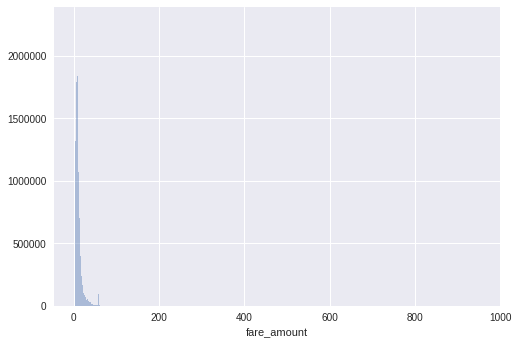

In [10]:
# seaborn.plt.xlim(0,60)
seaborn.distplot(df_train['fare_amount'],kde=False,bins=1000)

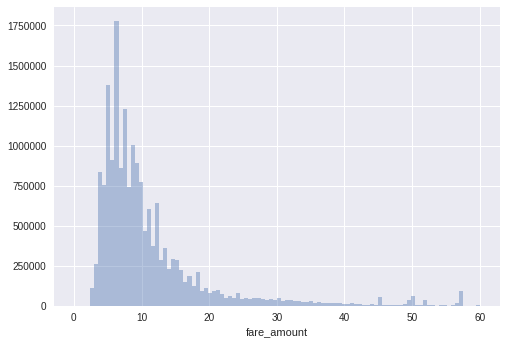

In [11]:
# seaborn.plt.xlim(0,60)
df_train= df_train[ df_train["fare_amount"] <=60 ]
seaborn.distplot(df_train['fare_amount'],kde=False,bins=100)

流石にあまりにも数が多いので、サンプリングを行います。割合としてはほぼ変わりません。

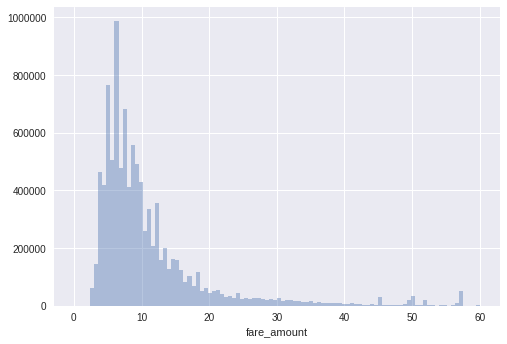

In [12]:
df_train = df_train.sample(n=10000000)
seaborn.distplot(df_train['fare_amount'],kde=False,bins=100)

深夜料金とかもありそうなので、pickup_datetimeのn時の部分を使います。

可能であれば直近の移動統計量も使いたかった人生やった。
あれ、乗客数って必要?

In [13]:
def hour(x):
    return int((x.split(' ')[1]).split(':')[0])
  
df_train['pickup_datetime']=df_train['pickup_datetime'].map(hour)
df_test['pickup_datetime']=df_test['pickup_datetime'].map(hour)

df_train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9328192,2015-01-26 18:03:22.0000003,6.50,18,-73.97,40.76,-73.96,40.78,2.00
10437819,2014-06-27 17:19:33.0000002,9.50,17,-73.96,40.77,-73.98,40.74,1.00
5116582,2012-03-03 20:24:00.000000159,16.10,20,-73.96,40.76,-74.01,40.72,1.00
2541666,2011-09-15 19:40:12.0000006,6.50,19,-73.99,40.73,-74.00,40.74,1.00
14595570,2011-05-13 22:25:09.0000001,8.10,22,-73.98,40.74,-73.97,40.76,1.00


**train / testのIDを全体から取り除いて、impを y_testとして取り出します**



In [14]:
X_train, X_valid =  train_test_split(df_train, test_size=0.1)

y_train = X_train['fare_amount']
X_train = X_train.drop(['key','fare_amount'], axis=1)

y_valid = X_valid['fare_amount']
X_valid = X_valid.drop(['key','fare_amount'], axis=1)

X_test  = df_test.drop(['key'], axis=1)


print('train size: ',X_train.shape,y_train.shape)
print('valid size: ',X_valid.shape,y_valid.shape)
print('test  size: ',X_test.shape)

train size:  (9000000, 6) (9000000,)
valid size:  (1000000, 6) (1000000,)
test  size:  (9914, 6)


### NN 今回はなし

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1],  activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


**学習はじめます**

※バッチサイズ！

とりあえず150epoch

In [0]:
history = model.fit(X_valid, y_valid,  epochs=100, batch_size=64)#, validation_data=(X_valid,y_valid))

Epoch 1/100
529646/529646 [==============================] - 9s 16us/step - loss: 6941.4488
Epoch 2/100
529646/529646 [==============================] - 9s 16us/step - loss: 6847.7503
Epoch 3/100
529646/529646 [==============================] - 9s 16us/step - loss: 6756.3765
Epoch 4/100
529646/529646 [==============================] - 9s 16us/step - loss: 6646.3356
Epoch 5/100
529646/529646 [==============================] - 8s 16us/step - loss: 6550.1431
Epoch 6/100
529646/529646 [==============================] - 8s 16us/step - loss: 6514.3124
Epoch 7/100
529646/529646 [==============================] - 9s 16us/step - loss: 6480.7967
Epoch 8/100
529646/529646 [==============================] - 9s 17us/step - loss: 6453.1803
Epoch 9/100
529646/529646 [==============================] - 9s 16us/step - loss: 6450.2434
Epoch 10/100
529646/529646 [==============================] - 8s 16us/step - loss: 6430.8698
Epoch 11/100
529646/529646 [==============================] - 8s 16us/step - lo

**acc / lossをグラフにプロットしてみる**

KeyError: ignored

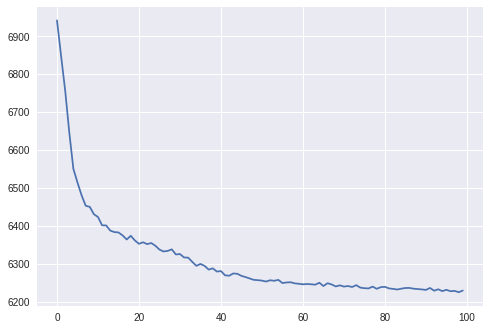

In [0]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**テストデータに試してみる**

### light GBM

In [0]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [0]:
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 31,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
}

gbm = lgb.train(params,
            lgb_train,
            num_boost_round=200,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)

[1]	valid_0's l2: 69.5769
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 62.0923
[3]	valid_0's l2: 54.8263
[4]	valid_0's l2: 49.6661
[5]	valid_0's l2: 44.6609
[6]	valid_0's l2: 40.4536
[7]	valid_0's l2: 36.6534
[8]	valid_0's l2: 33.8506
[9]	valid_0's l2: 31.6421
[10]	valid_0's l2: 29.5293
[11]	valid_0's l2: 27.5585
[12]	valid_0's l2: 25.9179
[13]	valid_0's l2: 24.7858
[14]	valid_0's l2: 23.7226
[15]	valid_0's l2: 22.6521
[16]	valid_0's l2: 21.7786
[17]	valid_0's l2: 20.9465
[18]	valid_0's l2: 20.2916
[19]	valid_0's l2: 19.87
[20]	valid_0's l2: 19.4677
[21]	valid_0's l2: 19.0089
[22]	valid_0's l2: 18.7228
[23]	valid_0's l2: 18.4502
[24]	valid_0's l2: 18.2338
[25]	valid_0's l2: 17.9653
[26]	valid_0's l2: 17.7275
[27]	valid_0's l2: 17.4738
[28]	valid_0's l2: 17.2073
[29]	valid_0's l2: 17.0161
[30]	valid_0's l2: 16.8696
[31]	valid_0's l2: 16.7817
[32]	valid_0's l2: 16.5995
[33]	valid_0's l2: 16.4942
[34]	valid_0's l2: 16.3627
[35]	valid_0's l2: 16.186
[36]	

In [0]:
prediction_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
prediction_lgbm

array([ 8.22235466,  8.58464226,  6.76850649, ..., 50.91730997,
       19.13055338,  7.85137537])

### light GBM + cv

In [0]:
import lightgbm as lgb

In [0]:
bst = lgb.LGBMRegressor(
                        num_leaves = 31,
                        learning_rate=0.01,
                        min_child_samples=10,
                        n_estimators=200,
                        max_depth=-1,
                        )

grid_param = {'n_estimators':[100,200],'max_depth':[4,8,16],'num_leaves':[31,15,7,3],'learning_rate':[0.1,0.05,0.01]}

fit_params={'early_stopping_rounds':10, 
            'eval_metric' : 'rmse', 
            'eval_set' : [(X_valid, y_valid)]
           }

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


bst_gs_cv = GridSearchCV(
            bst, # 識別器
            grid_param, # 最適化したいパラメータセット 
            cv = KFold(n_splits=3, shuffle=True), # 交差検定の回数
            scoring = 'neg_mean_squared_error',
            verbose = 0
            )

bst_gs_cv.fit(
            X_train, 
            y_train,
            **fit_params,
            verbose = 0
            )

best_param = bst_gs_cv.best_params_
print('Best parameter: {}'.format(best_param))

prediction_lgbm_cv = bst_gs_cv.predict(X_test)

### XGB

In [0]:
from xgboost import XGBRegressor

In [0]:
%%time
my_model = XGBRegressor(n_estimators=200, learning_rate=0.05)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], verbose=False)

Testデータに対して予測モデルの作成

In [0]:
prediction_xgb = my_model.predict(X_test)
# prediction = prediction.astype(int)
prediction_xgb

array([ 8.363173,  8.407717,  8.363173, ..., 49.587337, 17.125628,
        8.363173], dtype=float32)

### アンサンブル

In [0]:
prediction_en = prediction_xgb*0.5+prediction_lgbm*0.5

## 第4章　提出してみる


---


In [0]:
submission = pd.DataFrame()

keys = df_test['key'].values.tolist()
submission['key'] = keys
submission['fare_amount'] = prediction_lgbm_cv

submission.to_csv('submission.csv', index=False)
# files.download('submission.csv')
submission.head(10)

!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "lightGBM-CV!"